In [0]:
!pip install pydicom

     |████████████████████████████████| 7.0MB 3.2MB/s 


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%matplotlib inline
import numpy as np
from settings import Settings
from utils import *
from data_processor import data_processor
from augment_patient import augment_patient

In [0]:
Settings.data_dir = 'gdrive/stage1/'
Settings.labels_file = 'gdrive/stage1_labels.csv/stage1_labels.csv'

In [0]:
lungPatients, labels = load_data()

size = Settings.size
no_slices = Settings.no_slices

imageData = []
augData = []

for num, patient in enumerate(lungPatients):
    if num % 100 == 0:
        print('Saved -', num)
    try:
        patient_data = data_processor(patient=patient, labels_df=labels, size=size, noslices=no_slices, visualize=False)
        
        if get_label(patient, labels) == 1:
            augmented_data = []
            for i in range(Settings.aug_counter):
                augmented_data.append(augment_patient(patient=patient, labels_df=labels, iteration=i, size=size, noslices=no_slices, visualize=False))
            for each in augmented_data:
                augData.append([each['img_data'], each['label'], each['patient']])
    
        imageData.append([patient_data['img_data'], patient_data['label'], patient_data['patient']])
    except KeyError as e:
        print('Data is unlabeled')
    except Exception as er:
        print(er)

        
##Results are saved as numpy file
np.save('imageDataNew-{}-{}-{}.npy'.format(size, size, no_slices), imageData)
np.save('augmentedDataNew-{}-{}-{}.npy'.format(size, size, no_slices), augData)
print(imageData.shape)
print(augData.shape)

In [0]:
import tensorflow as tf
import pandas as pd
import tflearn
from tflearn.layers.conv import conv_3d, max_pool_3d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import numpy as np
import matplotlib.pyplot as plt

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
imageData = np.load('gdrive/My Drive/Colab Notebooks/imageDataNew-64-64-20.npy', allow_pickle=True)
trainingData = imageData[0:-100]
validationData = imageData[-100:]

# trainingData = np.load('gdrive/My Drive/Colab Notebooks/augmentedDataNew-50-50-20.npy', allow_pickle=True)

# np.random.shuffle(augData)

# trainingData = np.concatenate([trData, augData[:700]])

x = tf.placeholder('float')
y = tf.placeholder('float')
size = Settings.size
keep_rate = 0.8
NoSlices = Settings.no_slices

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Epoch 1 completed out of 10 loss: 43028034684928.0
Accuracy: 0.52
Epoch 2 completed out of 10 loss: 11048368095744.0
Accuracy: 0.61
Epoch 3 completed out of 10 loss: 4800619076608.0
Accuracy: 0.73
Epoch 4 completed out of 10 loss: 2943126845184.0
Accuracy: 0.68
Epoch 5 completed out of 10 loss: 1621171155520.0
Accuracy: 0.64
Epoch 6 completed out of 10 loss: 848599912416.0
Accuracy: 0.71
Epoch 7 completed out of 10 loss: 492056288192.125
Accuracy: 0.65
Epoch 8 completed out of 10 loss: 224763565728.0
Accuracy: 0.59
Epoch 9 completed out of 10 loss: 127472072088.5
Accuracy: 0.6
Epoch 10 completed out of 10 loss: 65837291880.0
Accuracy: 0.56
Final Accuracy: 0.64
Patient:  ee9c580272cd027

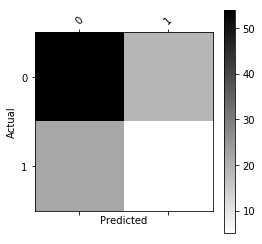

In [0]:
def convolution3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1, 1, 1, 1, 1], padding='SAME')


def maxpooling3d(x):
    return tf.nn.max_pool3d(x, ksize=[1, 2, 2, 2, 1], strides=[1, 2, 2, 2, 1], padding='SAME')


def cnn(x):
    x = tf.reshape(x, shape=[-1, size, size, NoSlices, 1])
    convolution1 = tf.nn.relu(
        convolution3d(x, tf.Variable(tf.random_normal([3, 3, 3, 1, 32]))) + tf.Variable(tf.random_normal([32])))
    convolution1 = maxpooling3d(convolution1)
    convolution2 = tf.nn.relu(
        convolution3d(convolution1, tf.Variable(tf.random_normal([3, 3, 3, 32, 64]))) + tf.Variable(
            tf.random_normal([64])))
    convolution2 = maxpooling3d(convolution2)
    convolution3 = tf.nn.relu(
        convolution3d(convolution2, tf.Variable(tf.random_normal([3, 3, 3, 64, 128]))) + tf.Variable(
            tf.random_normal([128])))
    convolution3 = maxpooling3d(convolution3)
    convolution4 = tf.nn.relu(
        convolution3d(convolution3, tf.Variable(tf.random_normal([3, 3, 3, 128, 256]))) + tf.Variable(
            tf.random_normal([256])))
    convolution4 = maxpooling3d(convolution4)
    convolution5 = tf.nn.relu(
        convolution3d(convolution4, tf.Variable(tf.random_normal([3, 3, 3, 256, 512]))) + tf.Variable(
            tf.random_normal([512])))
    convolution5 = maxpooling3d(convolution4)
    fullyconnected = tf.reshape(convolution5, [-1, 1024])
    fullyconnected = tf.nn.relu(
        tf.matmul(fullyconnected, tf.Variable(tf.random_normal([1024, 1024]))) + tf.Variable(tf.random_normal([1024])))
    fullyconnected = tf.nn.dropout(fullyconnected, keep_rate)
    output = tf.matmul(fullyconnected, tf.Variable(tf.random_normal([1024, 2]))) + tf.Variable(tf.random_normal([2]))
    return output


def network(x):
    prediction = cnn(x)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y))
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    epochs = 10
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        for epoch in range(epochs):
            epoch_loss = 0
            for data in trainingData:
                try:
                    X = data[0]
                    Y = data[1]
                    _, c = session.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                except Exception as e:
                    pass

            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
           # if tf.argmax(prediction, 1) == 0:
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
            print('Epoch', epoch + 1, 'completed out of', epochs, 'loss:', epoch_loss)
            # print('Correct:',correct.eval({x:[i[0] for i in validationData], y:[i[1] for i in validationData]}))
            print('Accuracy:', accuracy.eval({x: [i[0] for i in validationData], y: [i[1] for i in validationData]}))
        print('Final Accuracy:', accuracy.eval({x: [i[0] for i in validationData], y: [i[1] for i in validationData]}))
        patients = []
        actual = []
        predicted = []

        finalprediction = tf.argmax(prediction, 1)
        actualprediction = tf.argmax(y, 1)
        for i in range(len(validationData)):
            patients.append(validationData[i][2])
        for i in finalprediction.eval({x: [i[0] for i in validationData], y: [i[1] for i in validationData]}):
            if(i==1):
                predicted.append("Cancer")
            else:
                predicted.append("No Cancer")
        for i in actualprediction.eval({x: [i[0] for i in validationData], y: [i[1] for i in validationData]}):
            if(i==1):
                actual.append("Cancer")
            else:
                actual.append("No Cancer")
        for i in range(len(patients)):
            print("Patient: ",patients[i])
            print("Actual: ", actual[i])
            print("Predcited: ", predicted[i])

        from sklearn.metrics import confusion_matrix
        y_actual = pd.Series(
            (actualprediction.eval({x: [i[0] for i in validationData], y: [i[1] for i in validationData]})),
            name='Actual')
        y_predicted = pd.Series(
            (finalprediction.eval({x: [i[0] for i in validationData], y: [i[1] for i in validationData]})),
            name='Predicted')
        df_confusion = pd.crosstab(y_actual, y_predicted)
        print(df_confusion)

        ## Function to plot confusion matrix
        def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):\
            
            plt.matshow(df_confusion, cmap=cmap)  # imshow  
            # plt.title(title)
            plt.colorbar()
            tick_marks = np.arange(len(df_confusion.columns))
            plt.xticks(tick_marks, df_confusion.columns, rotation=45)
            plt.yticks(tick_marks, df_confusion.index)
            # plt.tight_layout()
            plt.ylabel(df_confusion.index.name)
            plt.xlabel(df_confusion.columns.name)
            plt.show()
        plot_confusion_matrix(df_confusion)
        # print(y_true,y_pred)
        # print(confusion_matrix(y_true, y_pred))
        # print(actualprediction.eval({x:[i[0] for i in validationData], y:[i[1] for i in validationData]}))
        # print(finalprediction.eval({x:[i[0] for i in validationData], y:[i[1] for i in validationData]}))
network(x)

In [0]:
import tensorflow as tf
import pandas as pd
import tflearn
from tflearn.layers.conv import conv_3d, max_pool_3d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

imageData = np.load('imageDataNew-50-50-20.npy')
trainingData = imageData[0:800]
testData = imageData[-1:]

x = tf.placeholder('float')
y = tf.placeholder('float')
size = 50
keep_rate = 0.8
NoSlices = 20


def convolution3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1, 1, 1, 1, 1], padding='SAME')


def maxpooling3d(x):
    return tf.nn.max_pool3d(x, ksize=[1, 2, 2, 2, 1], strides=[1, 2, 2, 2, 1], padding='SAME')


def cnn(x):
    x = tf.reshape(x, shape=[-1, size, size, NoSlices, 1])
    convolution1 = tf.nn.relu(
        convolution3d(x, tf.Variable(tf.random_normal([3, 3, 3, 1, 32]))) + tf.Variable(tf.random_normal([32])))
    convolution1 = maxpooling3d(convolution1)
    convolution2 = tf.nn.relu(
        convolution3d(convolution1, tf.Variable(tf.random_normal([3, 3, 3, 32, 64]))) + tf.Variable(
            tf.random_normal([64])))
    convolution2 = maxpooling3d(convolution2)
    convolution3 = tf.nn.relu(
        convolution3d(convolution2, tf.Variable(tf.random_normal([3, 3, 3, 64, 128]))) + tf.Variable(
            tf.random_normal([128])))
    convolution3 = maxpooling3d(convolution3)
    convolution4 = tf.nn.relu(
        convolution3d(convolution3, tf.Variable(tf.random_normal([3, 3, 3, 128, 256]))) + tf.Variable(
            tf.random_normal([256])))
    convolution4 = maxpooling3d(convolution4)
    convolution5 = tf.nn.relu(
        convolution3d(convolution4, tf.Variable(tf.random_normal([3, 3, 3, 256, 512]))) + tf.Variable(
            tf.random_normal([512])))
    convolution5 = maxpooling3d(convolution4)
    fullyconnected = tf.reshape(convolution5, [-1, 1024])
    fullyconnected = tf.nn.relu(
        tf.matmul(fullyconnected, tf.Variable(tf.random_normal([1024, 1024]))) + tf.Variable(tf.random_normal([1024])))
    fullyconnected = tf.nn.dropout(fullyconnected, keep_rate)
    output = tf.matmul(fullyconnected, tf.Variable(tf.random_normal([1024, 2]))) + tf.Variable(tf.random_normal([2]))
    return output


def network(x):
    prediction = cnn(x)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y))
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    epochs = 10
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        for epoch in range(epochs):
            epoch_loss = 0
            for data in trainingData:
                try:
                    X = data[0]
                    Y = data[1]
                    _, c = session.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                except Exception as e:
                    pass

        patients = []
        actual = []
        predicted = []

        finalprediction = tf.argmax(prediction, 1)
        actualprediction = tf.argmax(y, 1)
        for i in range(len(testData)):
            patients.append(testData[i][2])
        for i in finalprediction.eval({x: [i[0] for i in testData], y: [i[1] for i in testData]}):
            if(i==1):
                predicted.append("Cancer")
            else:
                predicted.append("No Cancer")

        for i in range(len(patients)):
            print("Patient: ",patients[i])
            print("Predcited: ", predicted[i])

     
network(x)